In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from definitions import ROOT_DIR
plt.rcParams.update({'font.size': 18})

In [2]:
def plot_baseline(plot_fname, ax1, ax2, legends, keys, plot=True):
    with open(plot_fname, 'r') as f:
        baseline = json.load(f)
        exp_factor_baseline = np.array([l for l in baseline['exploration_factors'] if l])
        avg_exp_factor_baseline = np.average(exp_factor_baseline, axis=0)

        ratio_visited_baseline = np.array([l for l in baseline['ratios_visited'] if l])
        avg_ratio_visited_baseline = np.average(ratio_visited_baseline, axis=0)

    x = np.arange(0, avg_exp_factor_baseline.shape[0])
    if plot:
        ax1.title.set_text('Exploration factor')
        b1, = ax1.plot(x, avg_exp_factor_baseline, color='blue')
        y_min_baseline = avg_exp_factor_baseline - np.std(exp_factor_baseline, axis=0)
        y_max_baseline = avg_exp_factor_baseline + np.std(exp_factor_baseline, axis=0)
        ax1.fill_between(x, y_min_baseline, y_max_baseline, color='blue', alpha=0.2)

        ax2.title.set_text('Ratio of states visited')
        b2, = ax2.plot(x, avg_ratio_visited_baseline, color='blue')
        y_min_baseline = avg_ratio_visited_baseline - np.std(ratio_visited_baseline, axis=0)
        y_max_baseline = avg_ratio_visited_baseline + np.std(ratio_visited_baseline, axis=0)
        ax2.fill_between(x, y_min_baseline, y_max_baseline, color='blue', alpha=0.2)

        legends.append(b1)
        keys.append('Random Baseline')
    
    return legends, keys, x

def find_match(substring, strings):
    for s in strings:
        if substring in s.lower():
            return substring
    return None

def exploration_plots(x, results, key, fig, ax1, ax2, legends, keys, color='orange'):
    key, title, titles = key
    mf = results[key]

    mf_plots = {k: [] for k in list(mf.values())[0].keys()}
    for fname, res in mf.items():
        for k in mf_plots.keys():
            
            mf_plots[k].append(res[k][1]['y'][:1000])

    try:
        exp_fac_plots = mf_plots['Exploration Factor for ep 0'] if 'Exploration Factor for ep 0' in mf_plots else mf_plots['Exploration Factor']
        vis_rat_plots = mf_plots['Ratio of states visited for ep 0'] if 'Ratio of states visited for ep 0' in mf_plots else mf_plots['Ratio of states visited']   
    except Exception:
        print(mf)
        print(mf_plots.keys())
    
    explr_fac = np.array(exp_fac_plots)
    visited_ratios = np.array(vis_rat_plots)

    return plot_means_with_std(x, explr_fac, visited_ratios, title, fig, ax1, ax2, legends, keys, color)

def plot_means_with_std(x, explr_fac, visited_ratios, title, fig, ax1, ax2, legends, keys, color='orange'):
    
    avg_mf_exploration_factor = np.average(explr_fac, axis=0)

    mf1, = ax1.plot(x, avg_mf_exploration_factor, color=color)

    avg_mf_ratios_visited = np.average(visited_ratios, axis=0)
    mf2, = ax2.plot(x, avg_mf_ratios_visited, color=color)
    
#     y_mins_ef = explr_fac.min(axis=0)
#     y_max_ef = explr_fac.max(axis=0)
    y_mins_ef = avg_mf_exploration_factor - np.std(explr_fac, axis=0)
    y_max_ef = avg_mf_exploration_factor + np.std(explr_fac, axis=0)
    ax1.fill_between(x, y_mins_ef, y_max_ef, color=color, alpha=0.2)
    
    y_mins_rv = avg_mf_ratios_visited - np.std(visited_ratios, axis=0)
    y_max_rv = avg_mf_ratios_visited + np.std(visited_ratios, axis=0)
    ax2.fill_between(x, y_mins_rv, y_max_rv, color=color, alpha=0.2)
    
    legends.append(mf1)
    keys.append(title)
    
    return mf1, legends, keys

In [5]:

def plot(baseline_fname, exp_dir, experiments):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # fig.suptitle("Open Labyrinth experiments steps=%d, trials=%d, size_maze=%d" % (n_steps, trials, size_maze), fontsize=16)
    ax1.set_ylim([0, 1.01])
    ax1.set_xlabel('environment steps')
    ax1.set_ylabel('# unique states visited /\n# total states visited', wrap=True)

    ax2.set_ylim([0, 1.01])
    ax2.set_xlabel('environment steps')
    ax2.set_ylabel('proportion of all states visited')

    ax1.grid(True)
    ax2.grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    legends = []
    keys = []

    colors = ['orange', 'purple', 'green', 'red', 'brown', 'cyan']

    legends, keys, x = plot_baseline(baseline_fname, ax1, ax2, legends, keys)


    fname = 'results.json'

    def compile_file(exp_dir, partial_id, fname):
        results = {}
        keys = ['exploration_factors', 'ratios_visited']
        for f in exp_dir.iterdir():
            if str(partial_id) in str(f) and f.is_dir():
                with open(f / fname, 'r') as fi:
                    res = json.load(fi)
                    for key in keys:
                        if key not in results:
                            results[key] = []
                        results[key].append(res[key][0])

        for key, value in results.items():
            results[key] = np.array(value)
        return results

    for i, (part_id, title) in enumerate(experiments):
        results = compile_file(exp_dir, part_id, fname)
        _, legends, keys = plot_means_with_std(x, results['exploration_factors'], results['ratios_visited'], title, fig, ax1, ax2, legends, keys, colors[i])
#         fig.legend((l for l in legends), (k for k in keys), 'lower right')

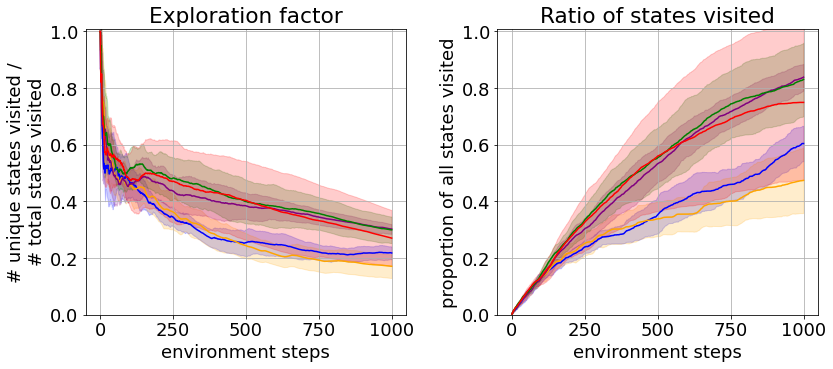

In [6]:
plot_dir = Path('plots')
nowalls_baseline_file = plot_dir / 'baselines' / 'random_agent_wallless_21.json'
nowalls_experiments = [
    (38902379, 'Count w/ Q-argmax'),
    (38791884, 'Novelty w/ Q-argmax'),
    (38791879, 'Novelty w/ Planning (d=1)'),
    (38791881, 'Novelty w/ Planning (d=5)')
]
nowalls_exp_dir = Path('experiments')

plot(nowalls_baseline_file, nowalls_exp_dir, nowalls_experiments)

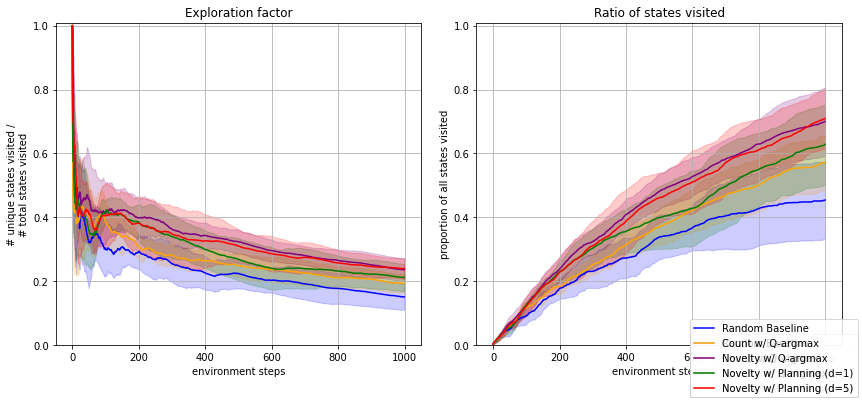

In [6]:
plot_dir = Path('plots')
walls_baseline_file = plot_dir / 'baselines' / 'random_agent_21.json'
walls_experiments = [
    (38902383, 'Count w/ Q-argmax'),
    (38791892, 'Novelty w/ Q-argmax'),
    (11690640, 'Novelty w/ Planning (d=1)'),
    (38791887, 'Novelty w/ Planning (d=5)')
]
walls_exp_dir = Path('experiments')

plot(walls_baseline_file, walls_exp_dir, walls_experiments)